In [163]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from sklearn.tree import plot_tree

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score, recall_score, precision_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.tokenize import word_tokenize#, sent_tokenize, RegexpTokenizer, wordpunct_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords#, wordnet

In [164]:
# Load dataframes and make a cobined dataframe for making models
df_appwatch = pd.read_csv('../data/apple_watch.csv')
df_galaxy = pd.read_csv('../data/galaxy_watch.csv')
df = pd.concat([df_appwatch, df_galaxy], axis=0)
print(f'apple watch dataframe shape ------------- {df_appwatch.shape}')
print(f'galaxy watch dataframe shape ------------ {df_galaxy.shape}')
print(f'final (combined) data frame shape ------- {df.shape}')

apple watch dataframe shape ------------- (1996, 5)
galaxy watch dataframe shape ------------ (1999, 5)
final (combined) data frame shape ------- (3995, 5)


In [165]:
df.head()

,Unnamed: 0,author,description,num_comments,subreddit
0,0,Mnml_Id,Those Apple Watch Ultra Mod kit are looking go...,0,AppleWatch
1,1,BigMasterDingDong,Is there a way to increase the time between a ...,0,AppleWatch
2,2,Cedar_Wood_State,Just want an app that I can use the record my ...,0,AppleWatch
3,3,clarebear-82,[removed]Fitness recovery app that monitors HR...,0,AppleWatch
4,4,tomo128,Move goal 300%,0,AppleWatch


In [166]:
# drop unusefull columns
df.drop(columns =['Unnamed: 0', 'author', 'num_comments'], inplace=True)

In [167]:
df['subreddit'].value_counts()

GalaxyWatch    1999
AppleWatch     1996
Name: subreddit, dtype: int64

In [168]:
# create label column (target column)
df['subreddit'] = df['subreddit'].map({'GalaxyWatch': 1, 'AppleWatch':0})

In [169]:
df.isna().sum()

description    0
subreddit      0
dtype: int64

In [170]:
df.dtypes

description    object
subreddit       int64
dtype: object

## Functions

#### Before starting modeling, I just made a funtion for stemming texts, which might be usefull for my models

In [171]:
# cite: Got help form Katie Sylvia
# a function for stemming
def stem_words(text):
    # Initialize the Porter stemmer
    stemmer = PorterStemmer()
    
    # Tokenize the text into individual words
    words = nltk.word_tokenize(text)
    
    # Stem each word and join them back into a string
    stemmed_words = [stemmer.stem(word) for word in words]
    stemmed_text = ' '.join(stemmed_words)
    
    return stemmed_text

#### After modeling, I'll use the following function for plotting most important futures

In [172]:
# cite: got that function from GA 603-lesson_random_forest (Katie Sylvia)
# and customized that to my project
def plot_feature_importance(importance,names,model_type):


    #Create a DataFrame using a Dictionary
    df = pd.DataFrame({'feature_names':names,
                       'feature_importance':importance})

    #Sort the DataFrame in order decreasing feature importance
    df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    top_fe_df = df.head(20)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    
    #Plot Searborn bar chart
    sns.barplot(x=top_fe_df['feature_importance'], y=top_fe_df['feature_names'])
    
    #Add chart labels
    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')
    

## Modeling

In [173]:
# define X (features) and y(target)
X = df['description']
y = df['subreddit']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)
print(f'X shape ---------- {X.shape}')
print(f'y shape ---------- {y.shape}')

X shape ---------- (3995,)
y shape ---------- (3995,)


### Baseline accuracy

In [174]:
y_test.value_counts(normalize=True)

1    0.500501
0    0.499499
Name: subreddit, dtype: float64

Baseline accuracy score is 0.50

## Random Forest Algorithm with CountVectorizer

In [175]:
# describe pipeline with multinomial Naïve Bayes algorithm with countvectorizer transformer
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('rf', RandomForestClassifier())
])

In [176]:
# get to know pipeline params
pipe.get_params()

{'memory': None,
 'steps': [('cvec', CountVectorizer()), ('rf', RandomForestClassifier())],
 'verbose': False,
 'cvec': CountVectorizer(),
 'rf': RandomForestClassifier(),
 'cvec__analyzer': 'word',
 'cvec__binary': False,
 'cvec__decode_error': 'strict',
 'cvec__dtype': numpy.int64,
 'cvec__encoding': 'utf-8',
 'cvec__input': 'content',
 'cvec__lowercase': True,
 'cvec__max_df': 1.0,
 'cvec__max_features': None,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 1),
 'cvec__preprocessor': None,
 'cvec__stop_words': None,
 'cvec__strip_accents': None,
 'cvec__token_pattern': '(?u)\\b\\w\\w+\\b',
 'cvec__tokenizer': None,
 'cvec__vocabulary': None,
 'rf__bootstrap': True,
 'rf__ccp_alpha': 0.0,
 'rf__class_weight': None,
 'rf__criterion': 'gini',
 'rf__max_depth': None,
 'rf__max_features': 'auto',
 'rf__max_leaf_nodes': None,
 'rf__max_samples': None,
 'rf__min_impurity_decrease': 0.0,
 'rf__min_samples_leaf': 1,
 'rf__min_samples_split': 2,
 'rf__min_weight_fraction_leaf': 0.0,
 'rf__n_est

In [192]:
# set pipeline params by cvec
pipe_params = {
    'cvec__tokenizer': [None, stem_words],
    'cvec__max_features': [5_000, 10_000, 20_000, 30_000],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__stop_words': [None, 'english'],
    'cvec__ngram_range': [(1, 1), (1, 2)],
    'rf__max_depth': [None, 1, 2, 3, 4],
    'rf__n_estimators': [100]
}

In [193]:
# Grid search over with pipeline estimator
gs = GridSearchCV(pipe, param_grid=pipe_params, cv=5, n_jobs=5)

# fit the model to traning data
gs.fit(X_train, y_train)

# get to know wich params were best ones
print(f'The best params  ---------- {gs.best_params_}')

# get to know the best score
print(f'The best score  ----------- {gs.best_score_}')

The best params  ---------- {'cvec__max_df': 0.9, 'cvec__max_features': 10000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': 'english', 'cvec__tokenizer': None, 'rf__max_depth': None, 'rf__n_estimators': 100}
The best score  ----------- 0.886852531997774


In [219]:
# train data score
gs.score(X_train, y_train)

0.9983311081441922

In [220]:
# test data score
gs.score(X_test, y_test)

0.8838838838838838

C:\Users\sarvin.farhad\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


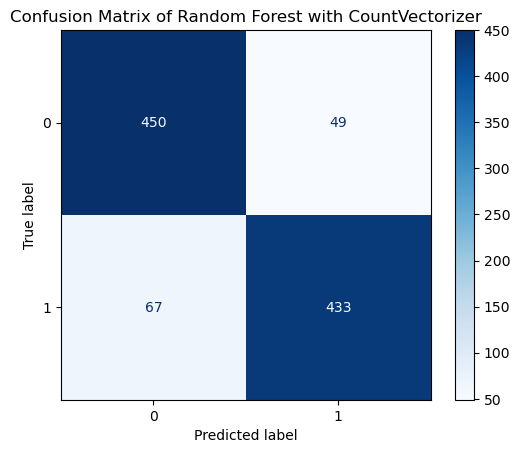

In [223]:
# Get predictions
preds = gs.predict(X_test)

#confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

# confusion matrix
plot_confusion_matrix(gs, X_test, y_test, cmap='Blues', values_format='d')
plt.title('Confusion Matrix of Random Forest with CountVectorizer');

### Evaluation for Model with Random Forest Algorithm and CountVectorizer Transformer

In [197]:
print(f'The accuracy score  ---------- {accuracy_score(y_test, preds)}')
print(f'The precision score  --------- {precision_score(y_test, preds)}')
print(f'The sensitivity score  ------- {recall_score(y_test, preds)}')
print(f'The specifity score  --------- {tn/(tn + fp)}')

The accuracy score  ---------- 0.8838838838838838
The precision score  --------- 0.8983402489626556
The sensitivity score  ------- 0.866
The specifity score  --------- 0.9018036072144289


### Feature Importance with CountVectorizer

Here I instantiated a CountVectorizer based on the best params that I got from GridSearch and then fit and transformed train data with that CountVectorizer. Also in the following, used defined function to plot top 20 features.

In [198]:
# instantiate TfidfVectorizer with best params 
cvec = CountVectorizer(max_df=0.9, max_features=10000, min_df=2, ngram_range=(1,1),
                       stop_words='english', tokenizer=None)
# make a train dataframe based on transformed data
X_train_df = pd.DataFrame(cvec.fit_transform(X_train).todense(), 
                          columns=cvec.get_feature_names())

C:\Users\sarvin.farhad\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [199]:
# get to know feature importances
gs.best_estimator_._final_estimator.feature_importances_

array([9.31612039e-05, 8.70836854e-05, 8.22030680e-06, ...,
       6.44070621e-05, 8.91464628e-06, 2.26411937e-04])

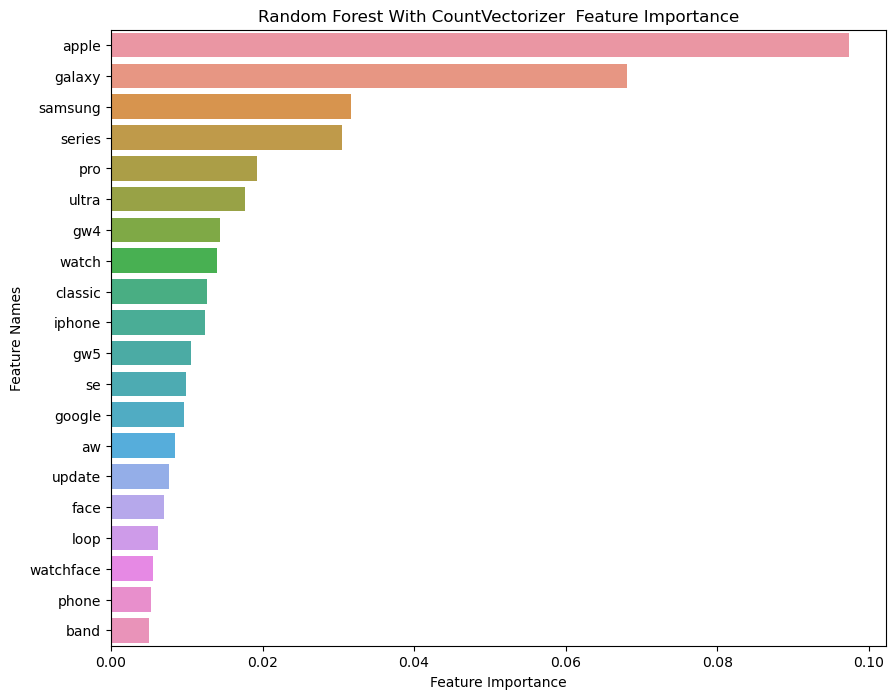

In [200]:
# plot top 20 features
plot_feature_importance(gs.best_estimator_._final_estimator.feature_importances_,
                        X_train_df.columns,'Random Forest With CountVectorizer ')

### Visualizing one of the trees

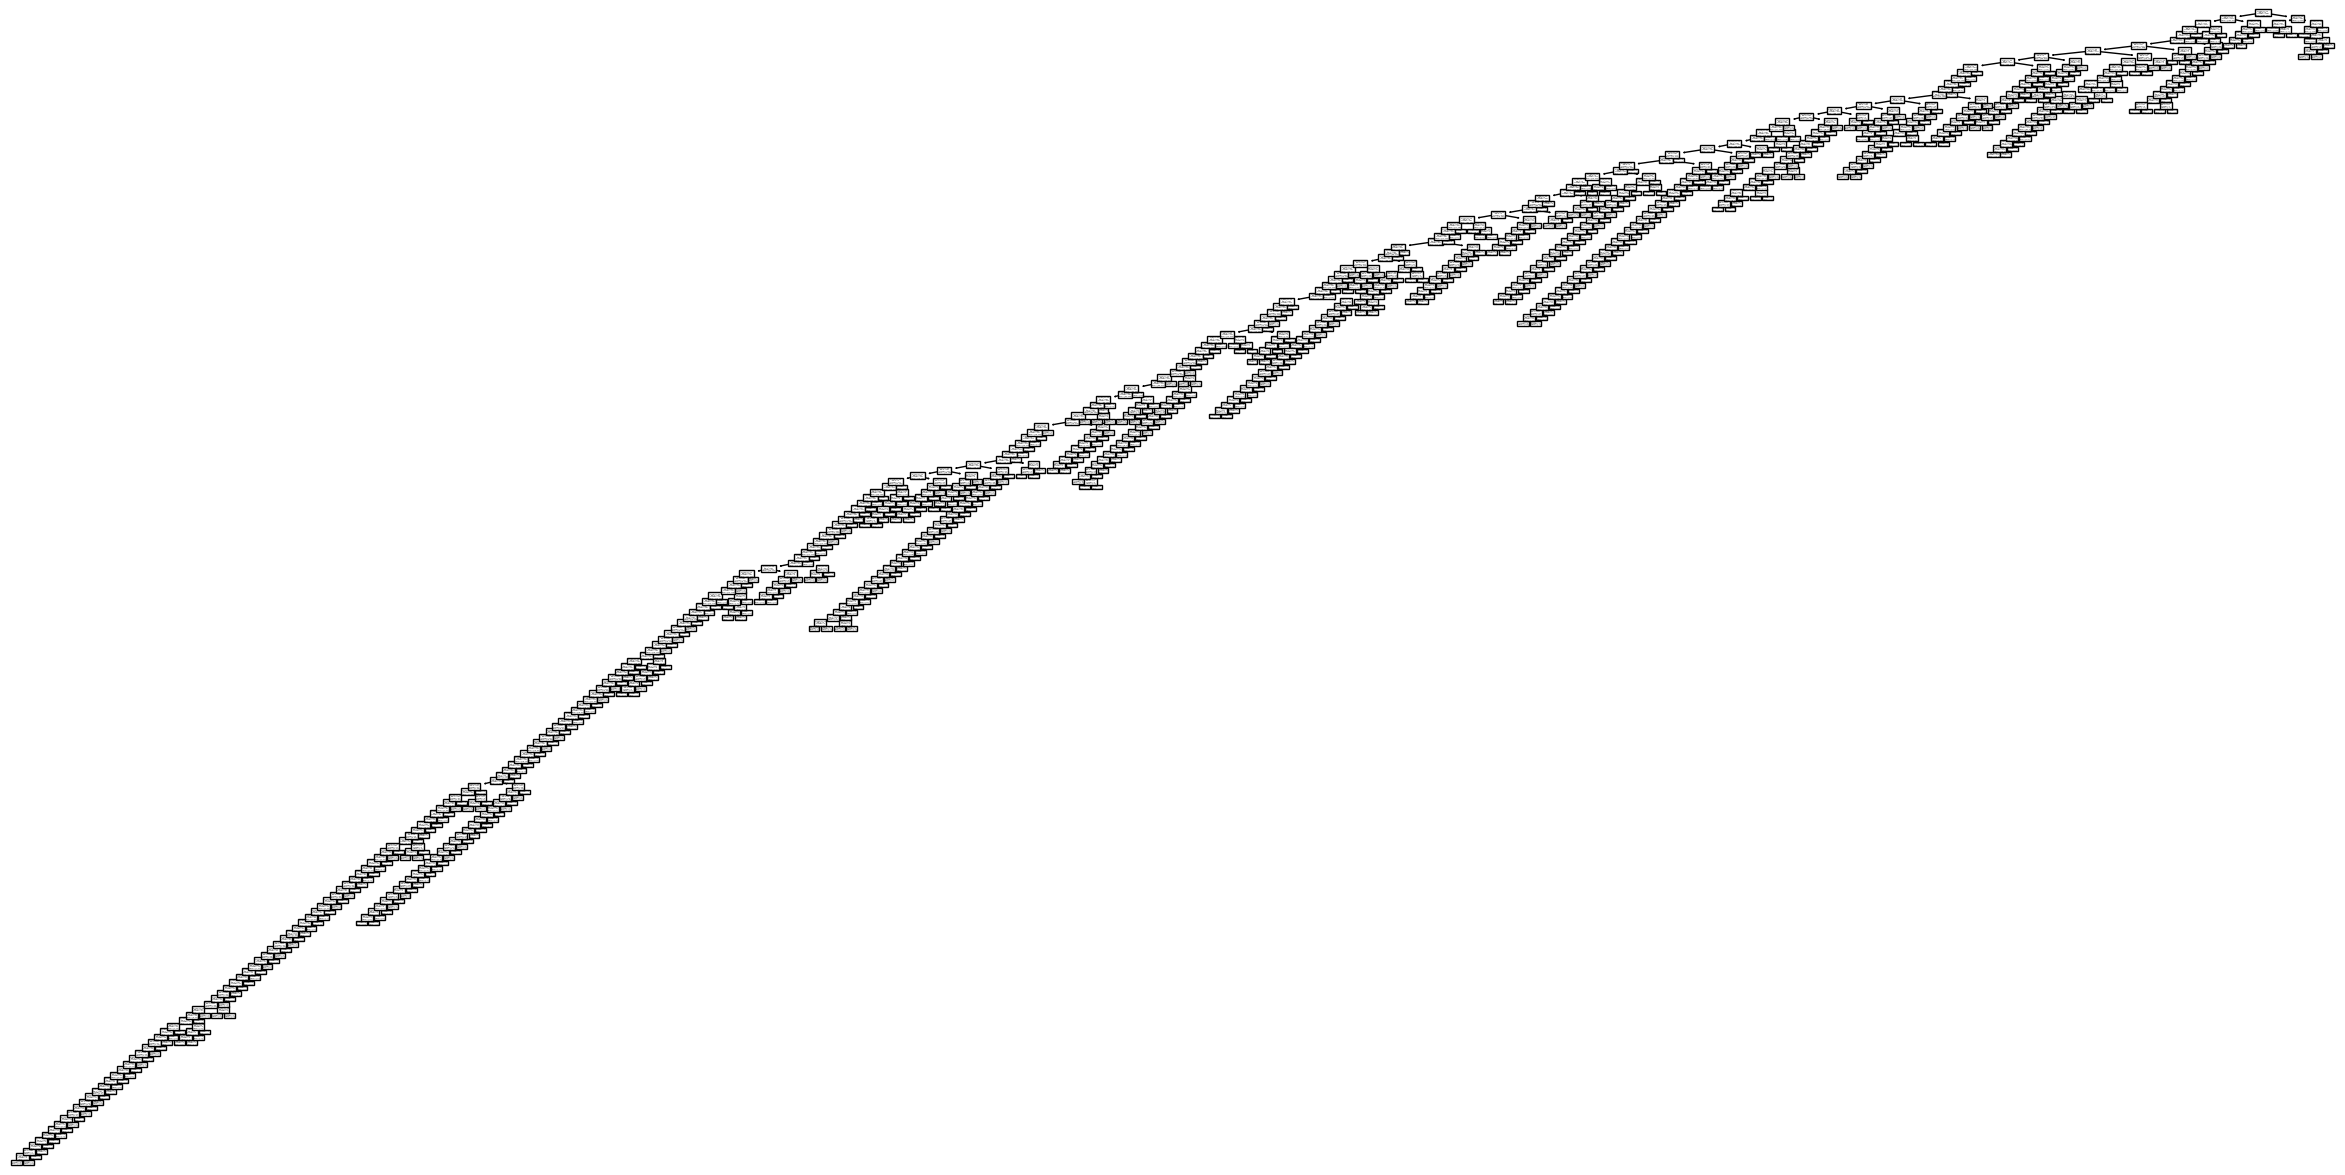

In [201]:
# plotting one of the trees (first one) in best estimator
plt.figure(figsize = (30,15))
plot_tree(gs.best_estimator_._final_estimator[0]);

## Random Forest Algorithm with TfidVectorizer

In [202]:
# redifine training and testing split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [203]:
# describe pipeline with multinomial Naïve Bayes algorithm with tfidvectorizer transformer
pipe_tvec = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('rf', RandomForestClassifier())
])

In [204]:
# get to know pipeline params
pipe_tvec.get_params()

{'memory': None,
 'steps': [('tvec', TfidfVectorizer()), ('rf', RandomForestClassifier())],
 'verbose': False,
 'tvec': TfidfVectorizer(),
 'rf': RandomForestClassifier(),
 'tvec__analyzer': 'word',
 'tvec__binary': False,
 'tvec__decode_error': 'strict',
 'tvec__dtype': numpy.float64,
 'tvec__encoding': 'utf-8',
 'tvec__input': 'content',
 'tvec__lowercase': True,
 'tvec__max_df': 1.0,
 'tvec__max_features': None,
 'tvec__min_df': 1,
 'tvec__ngram_range': (1, 1),
 'tvec__norm': 'l2',
 'tvec__preprocessor': None,
 'tvec__smooth_idf': True,
 'tvec__stop_words': None,
 'tvec__strip_accents': None,
 'tvec__sublinear_tf': False,
 'tvec__token_pattern': '(?u)\\b\\w\\w+\\b',
 'tvec__tokenizer': None,
 'tvec__use_idf': True,
 'tvec__vocabulary': None,
 'rf__bootstrap': True,
 'rf__ccp_alpha': 0.0,
 'rf__class_weight': None,
 'rf__criterion': 'gini',
 'rf__max_depth': None,
 'rf__max_features': 'auto',
 'rf__max_leaf_nodes': None,
 'rf__max_samples': None,
 'rf__min_impurity_decrease': 0.0,
 '

In [205]:
# set pipeline params by tvec
pipe_tvec_params = {
    'tvec__tokenizer': [None, stem_words],
    'tvec__max_features': [5_000, 10_000, 20_000, 30_000],
    'tvec__min_df': [2, 3],
    'tvec__max_df': [.9, .95],
    'tvec__stop_words': [None, 'english'],
    'tvec__ngram_range': [(1, 1), (1, 2)],
    'rf__max_depth': [None, 1, 2, 3, 4],
    'rf__n_estimators': [100]
}

In [206]:
# Grid search over with pipeline estimator
gs_tvec = GridSearchCV(pipe_tvec, param_grid=pipe_tvec_params, cv=5, n_jobs=5)

# fit the model to traning data
gs_tvec.fit(X_train, y_train)

# get to know wich params were best ones
print(f'The best params  ---------- {gs_tvec.best_params_}')

# get to know the best score
print(f'The best score  ----------- {gs_tvec.best_score_}')

The best params  ---------- {'rf__max_depth': None, 'rf__n_estimators': 100, 'tvec__max_df': 0.95, 'tvec__max_features': 20000, 'tvec__min_df': 3, 'tvec__ngram_range': (1, 1), 'tvec__stop_words': None, 'tvec__tokenizer': None}
The best score  ----------- 0.8855180856983862


In [207]:
# train data score
gs_tvec.score(X_train, y_train)

0.9989986648865153

In [208]:
# test data score
gs_tvec.score(X_test, y_test)

0.8888888888888888

C:\Users\sarvin.farhad\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


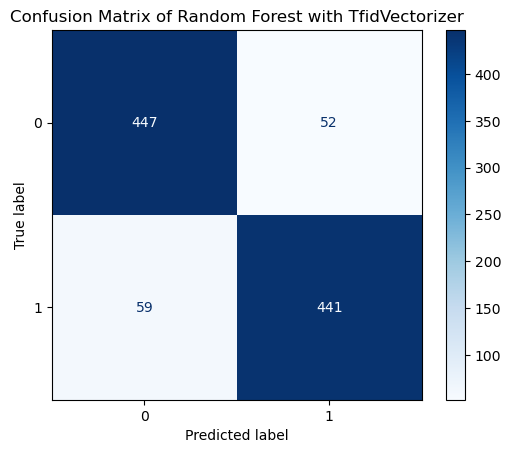

In [209]:
# Get predictions
preds = gs_tvec.predict(X_test)

#confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

# confusion matrix
plot_confusion_matrix(gs_tvec, X_test, y_test, cmap='Blues', values_format='d')
plt.title('Confusion Matrix of Random Forest with TfidVectorizer');

### Evaluation for Model with Random Forest Algorithm and TfidVectorizer Transformer

In [210]:
print(f'The accuracy score with  ----- {accuracy_score(y_test, preds)}')
print(f'The precision score   -------- {precision_score(y_test, preds)}')
print(f'The sensitivity score  ------- {recall_score(y_test, preds)}')
print(f'The specifity score  --------- {tn/(tn + fp)}')

The accuracy score with  ----- 0.8888888888888888
The precision score   -------- 0.8945233265720081
The sensitivity score  ------- 0.882
The specifity score  --------- 0.8957915831663327


### Feature Importance with Random Forest Algorithm and TfidVectorizer Transformer

Here I instantiated a TfidfVectorizer based on the best params that I got from GridSearch and then fit and transformed train data with that TfidfVectorizer. Also in the following used defined function to plot top 20 features.

In [ ]:
'tvec__max_df': 0.95, 'tvec__max_features': 20000, 'tvec__min_df': 3,
'tvec__ngram_range': (1, 1), 'tvec__stop_words': None,

In [215]:
# instantiate TfidfVectorizer with best params 
tvec = TfidfVectorizer(max_df=0.95, max_features=20000, min_df=3, ngram_range=(1,1),
                       stop_words=None, tokenizer=None)
# make a train dataframe based on transformed data
X_train_tvec_df = pd.DataFrame(tvec.fit_transform(X_train).todense(), 
                          columns=tvec.get_feature_names())

C:\Users\sarvin.farhad\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [216]:
# get to know feature importances
gs_tvec.best_estimator_._final_estimator.feature_importances_

array([3.29423938e-05, 4.37726929e-05, 2.86362601e-05, ...,
       1.05939094e-05, 0.00000000e+00, 1.21914693e-04])

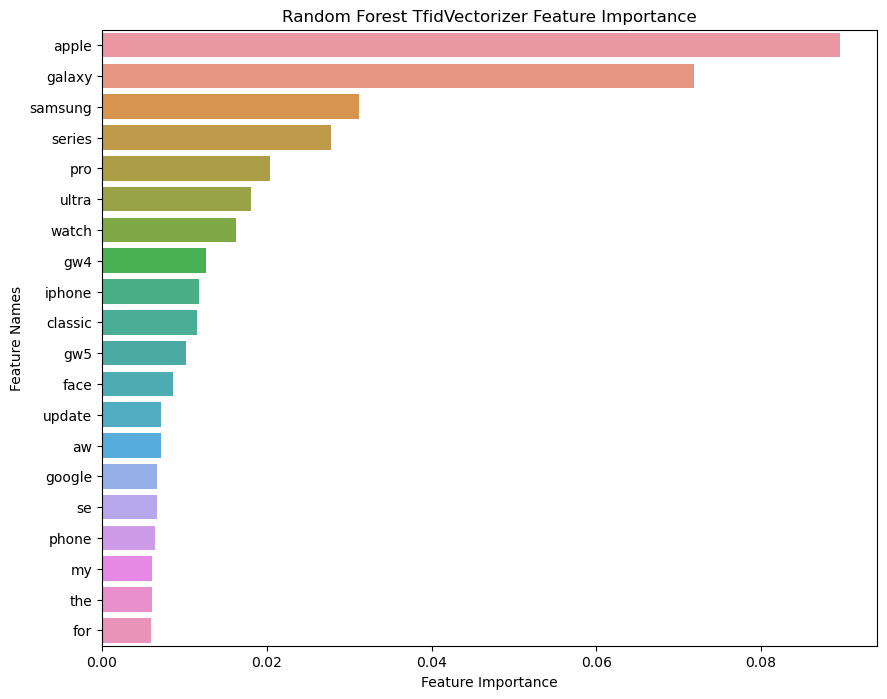

In [217]:
# plot top 20 features
plot_feature_importance(gs_tvec.best_estimator_._final_estimator.feature_importances_,
                        X_train_tvec_df.columns,'Random Forest TfidVectorizer')

### Visualizing one of the trees

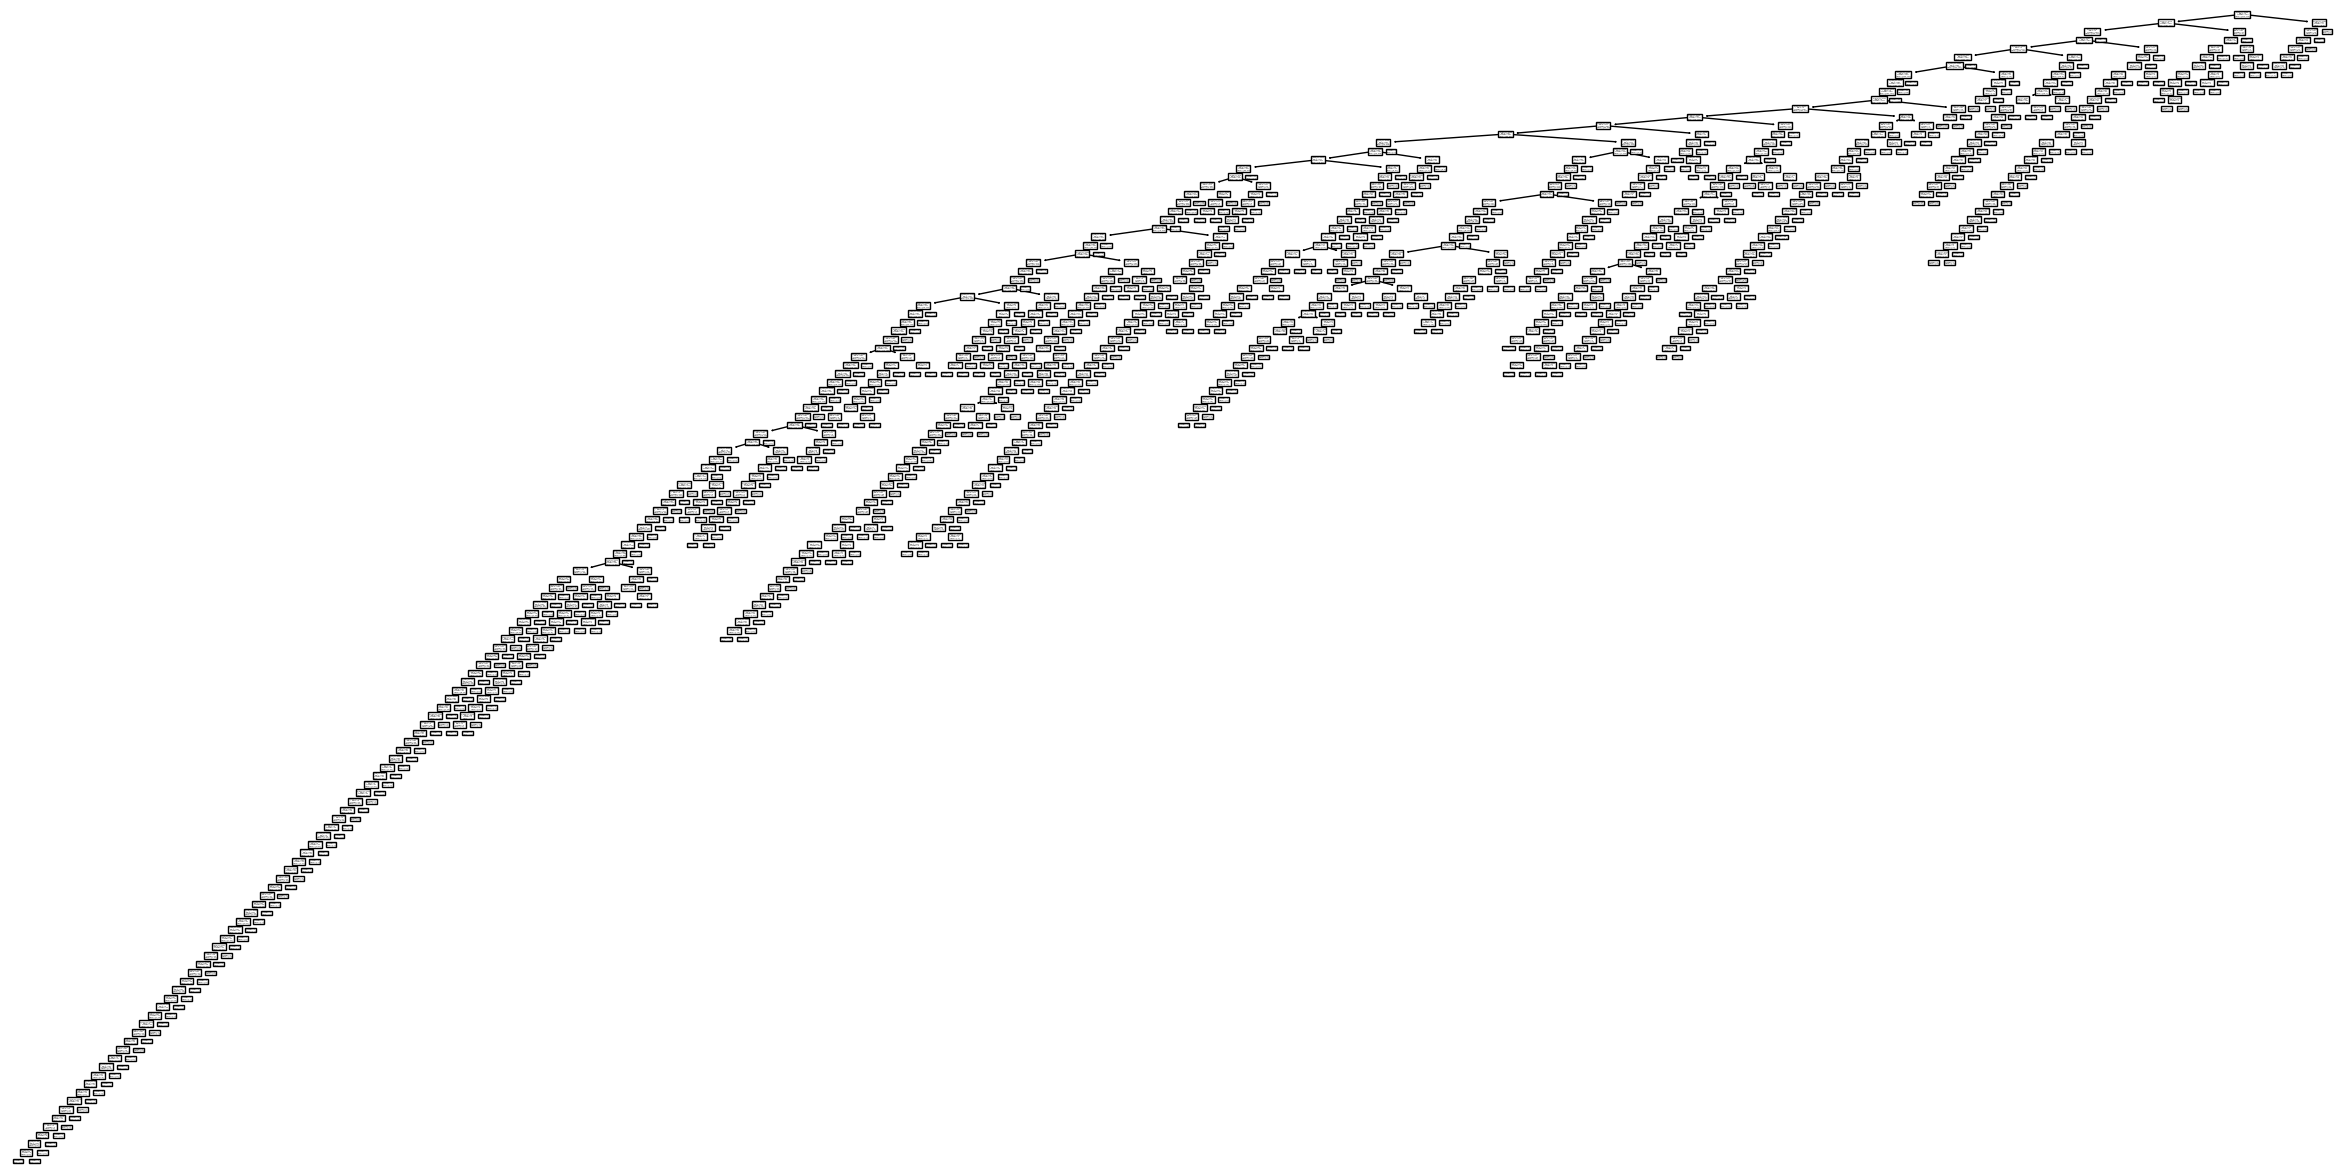

In [218]:
# plotting one of the trees (first one) in best estimator
plt.figure(figsize = (30,15))
plot_tree(gs_tvec.best_estimator_._final_estimator[0]);